## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №32. Часть 2.

#### Оценить возраст человека по изображению. 

В качестве датасета взят датасет лиц по ссылке 
https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar

In [1]:
import numpy as np
import pandas as pd

import cv2
from PIL import Image
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical

from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score

RANDOM_STATE = 42

print('Cuda version: ' + tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('OpenCV version ' + cv2.__version__)

Cuda version: 2.10.1
Num GPUs Available:  1
OpenCV version 4.7.0


Загружаем описание набора данных

In [2]:
df = pd.read_csv('wiki_crops.csv')
df.head(5)

,Unnamed: 0,file_path,label
0,0,wiki_crop\cropped\10049200_1891-09-16_1958.jpg,67
1,1,wiki_crop\cropped\10110600_1985-09-17_2012.jpg,27
2,2,wiki_crop\cropped\1013900_1917-10-15_1960.jpg,43
3,3,wiki_crop\cropped\10166400_1960-03-12_2008.jpg,48
4,4,wiki_crop\cropped\10292500_1984-03-26_2009.jpg,25


Проверим распределение изображений по меткам предполагаемого возраста

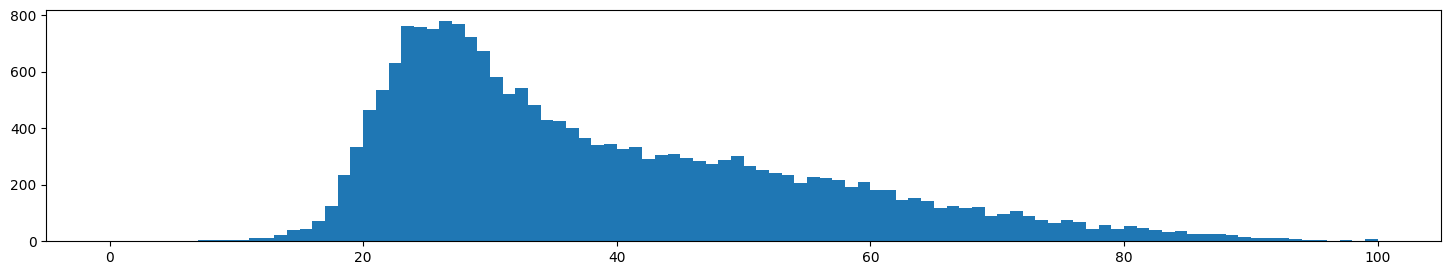

In [3]:
plt.figure(figsize=(18,3))
plt.hist(df.label, bins = df.label.nunique())
plt.show()

Выполним секвестр классов согласно предложенной возрастной классификации  

In [4]:
# Удалить записи с метками < 7
df.drop(df[df.label < 7].index, inplace=True)

AGE_CATS = [
    #'(0-3)','(4-6)',
    '(7-12)','(13-20)','(21-27)','(28-33)','(34-45)','(46-59)','(60-79)','(80++)'
    ]

#df.loc[(df.label > 0) & (df.label <= 3) , 'label'] = 0 
#df.loc[(df.label > 3) & (df.label <= 6) , 'label'] = 1 
df.loc[(df.label > 0) & (df.label <= 12) , 'label'] = 0 
df.loc[(df.label > 12) & (df.label <= 20) , 'label'] = 1
df.loc[(df.label > 20) & (df.label <= 27) , 'label'] = 2
df.loc[(df.label > 27) & (df.label <= 33) , 'label'] = 3
df.loc[(df.label > 33) & (df.label <= 45) , 'label'] = 4
df.loc[(df.label > 45) & (df.label <= 59) , 'label'] = 5
df.loc[(df.label > 59) & (df.label <= 79) , 'label'] = 6
df.loc[(df.label > 79), 'label'] = 7   

df.label.value_counts()

2    4986
4    4170
3    3522
5    3415
6    2096
1    1333
7     388
0      42
Name: label, dtype: int64

Сформируем из изображений набор данных, как набор массивов монохромных изображений, приведенных к единому разрешению

In [5]:
X = []
labels = []

# Загрузка изображений и формирования набора признаков
for index, row in tqdm(df.iterrows()):
    
    img = np.asarray(Image.open(row.file_path))
    
    blob = cv2.dnn.blobFromImage(img, scalefactor=1/255, size=(64, 64))
    X.append(np.asarray(blob[0][0]))

    labels.append(row.label)

X = np.asarray(X)
labels = np.asarray(labels)

print(f'Загружен массив изображений\n {X.shape}')

19952it [00:07, 2744.77it/s]


Загружен массив изображений
 (19952, 64, 64)


In [6]:
# Конвертируем целевые метки классов в разряженный массив (One-hot)
num_classes = len(np.unique(labels))
y = to_categorical(labels, num_classes=num_classes)

# Перемешаем случайным образом исходные массивы изображений и меток
indices = np.arange(X.shape[0])

np.random.seed(RANDOM_STATE)
np.random.shuffle(indices)
X, y = X[indices], y[indices]

# Выполним разбиение масивов на обучающий и тестовый наборы
train_length = int(X.shape[0] * 0.7)
X_train, X_test = X[:train_length], X[train_length:]
y_train, y_test = y[:train_length], y[train_length:]

Проверим один из элементов получившихся наборов данных

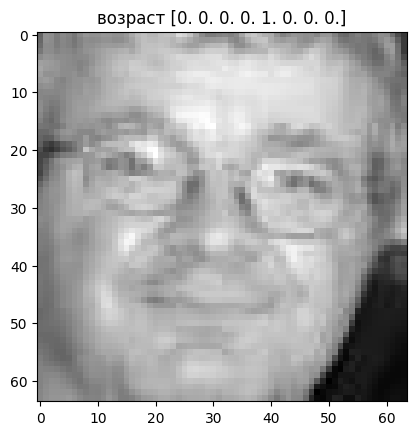

In [7]:
plt.imshow(X_train[0], cmap='gray')
plt.title(f'возраст {y_train[0]}');

Построим первую модель на базе плотной нейронной сети (DNN)

In [8]:
def DNNClassifier(input_shape, num_classes):
    model_input = layers.Input(shape=input_shape) 

    x = layers.Flatten()(model_input)
    x = layers.Dense(4096, activation='LeakyReLU')(x)
    x = layers.BatchNormalization()(x)
    
    model_output = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.models.Model(model_input, model_output, name= 'DNNClassifier_model')

In [9]:
keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

model_DNN = DNNClassifier((64,64,1), num_classes)

model_DNN.compile(
    optimizer=keras.optimizers.Nadam(0.01),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]) 

model_DNN.summary()

Model: "DNNClassifier_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 4096)              16781312  
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 8)                 32776     
                                                                 
Total params: 16,830,472
Trainable params: 16,822,280
Non-trainable params: 8,192
_______________________________

In [10]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.1,
        patience=2
    )]

history1 = model_DNN.fit(X_train, y_train, batch_size=512, epochs=25, callbacks=callbacks, validation_split=0.2, verbose=1)

Epoch 1/25
22/22 [==============================] - 2s 36ms/step - loss: 14.2382 - categorical_accuracy: 0.1707 - val_loss: 109.6884 - val_categorical_accuracy: 0.0977 - lr: 0.0100
Epoch 2/25
22/22 [==============================] - 1s 27ms/step - loss: 7.5494 - categorical_accuracy: 0.2250 - val_loss: 30.5510 - val_categorical_accuracy: 0.1732 - lr: 0.0100
Epoch 3/25
22/22 [==============================] - 1s 27ms/step - loss: 5.5976 - categorical_accuracy: 0.2160 - val_loss: 100.6127 - val_categorical_accuracy: 0.0225 - lr: 0.0100
Epoch 4/25
22/22 [==============================] - 1s 27ms/step - loss: 4.8295 - categorical_accuracy: 0.2304 - val_loss: 11.5861 - val_categorical_accuracy: 0.2047 - lr: 0.0100
Epoch 5/25
22/22 [==============================] - 1s 27ms/step - loss: 3.6235 - categorical_accuracy: 0.2366 - val_loss: 4.7168 - val_categorical_accuracy: 0.2072 - lr: 0.0100
Epoch 6/25
22/22 [==============================] - 1s 27ms/step - loss: 3.1214 - categorical_accuracy:

In [11]:
scores = model_DNN.evaluate(X_test, y_test, verbose=0)

print("Точность на тестовых данных: %.2f%%" % (scores[1]*100))

Точность на тестовых данных: 32.26%


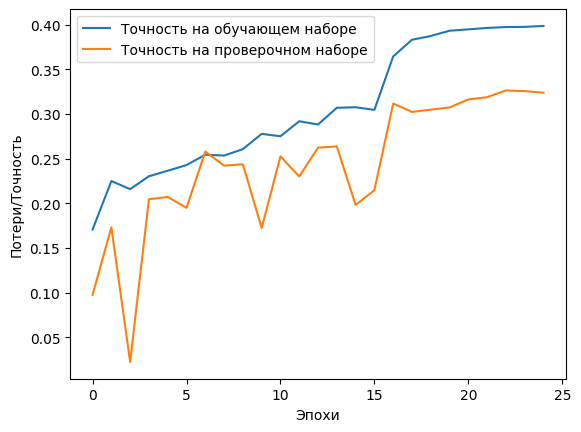

In [12]:
plt.plot(history1.history['categorical_accuracy'], label='Точность на обучающем наборе')
plt.plot(history1.history['val_categorical_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери/Точность')
plt.legend()
plt.show()

Построим вторую модель на базе сверточной нейронной сети

In [13]:
def CNNClassifier(input_shape, num_classes):
    model_input = layers.Input(shape=input_shape) 

    x = layers.Conv2D(32, 3, activation='relu')(model_input) 
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(2)(x) 

    x = layers.Conv2D(64, 3, activation='relu')(x) 
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(2)(x) 

    x = layers.Conv2D(128, 3, activation='relu')(x) 
    x = layers.MaxPool2D(2)(x) 
    x = layers.Dropout(0.2)(x) 
    
    x = layers.Flatten()(x) 
    x = layers.Dense(units=1024, activation='relu')(x) 
    
    model_output = layers.Dense(num_classes, activation='softmax')(x)  
    return keras.models.Model(model_input, model_output, name= 'CNNClassifier_model')



In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

model_CNN = CNNClassifier((64,64,1), num_classes)

model_CNN.compile(
    optimizer=keras.optimizers.Nadam(0.01),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]) 

model_CNN.summary()

Model: "CNNClassifier_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64

In [15]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2)
]

history2 = model_CNN.fit(X_train, y_train, batch_size=512, epochs=30, callbacks=callbacks, validation_split=0.2, verbose=1)

Epoch 1/30
22/22 [==============================] - 5s 112ms/step - loss: 65.3037 - categorical_accuracy: 0.2083 - val_loss: 2.0199 - val_categorical_accuracy: 0.1897 - lr: 0.0100
Epoch 2/30
22/22 [==============================] - 2s 70ms/step - loss: 1.7308 - categorical_accuracy: 0.2904 - val_loss: 1.9969 - val_categorical_accuracy: 0.2591 - lr: 0.0100
Epoch 3/30
22/22 [==============================] - 2s 71ms/step - loss: 1.6593 - categorical_accuracy: 0.3138 - val_loss: 1.9717 - val_categorical_accuracy: 0.2591 - lr: 0.0100
Epoch 4/30
22/22 [==============================] - 2s 70ms/step - loss: 1.6126 - categorical_accuracy: 0.3350 - val_loss: 1.9517 - val_categorical_accuracy: 0.1478 - lr: 0.0100
Epoch 5/30
22/22 [==============================] - 2s 70ms/step - loss: 1.5640 - categorical_accuracy: 0.3626 - val_loss: 1.8717 - val_categorical_accuracy: 0.2187 - lr: 0.0100
Epoch 6/30
22/22 [==============================] - 2s 70ms/step - loss: 1.6696 - categorical_accuracy: 0.32

In [16]:
scores = model_CNN.evaluate(X_test, y_test, verbose=0)
print("Точность на тестовых данных: %.2f%%" % (scores[1]*100))

Точность на тестовых данных: 34.58%


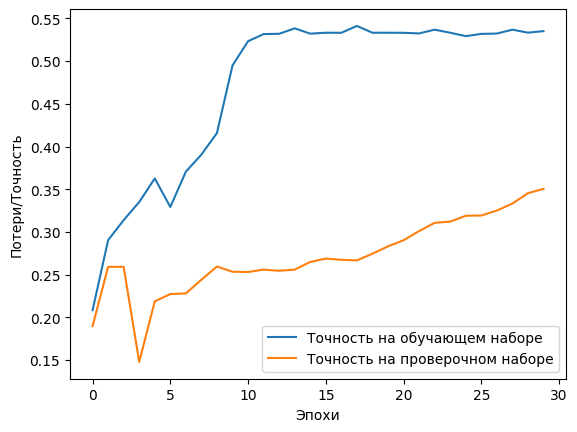

In [17]:
plt.plot(history2.history['categorical_accuracy'], label='Точность на обучающем наборе')
plt.plot(history2.history['val_categorical_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери/Точность')
plt.legend()
plt.show()

Выполним объединение моделей

In [18]:
def ConcClassifier(models, input_shape, num_classes):
    # Входной слой моделей
    model_input = layers.Input(shape=input_shape)
    # Выходы для каждой модели
    model_outputs = [md(model_input) for md in models]

    # Объединение выходов моделей в один слой
    x = layers.Concatenate()(model_outputs) 
    # Дополнительные слои
    x = layers.Dropout(0.2)(x) 
    # Выход объединенной модели
    model_output = layers.Dense(num_classes, activation='softmax')(x)

    # Возвращаем объедененную модель
    return keras.models.Model(model_input, model_output, name='ConcClassifier_model')

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

# Список объеденяемых моделей
models = [model_DNN, model_CNN]

model_CONC = ConcClassifier(models, (64,64,1), num_classes)

model_CONC.compile(
    optimizer=keras.optimizers.Nadam(0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]) 

model_CONC.summary()

Model: "ConcClassifier_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 DNNClassifier_model (Functiona  (None, 8)           16830472    ['input_1[0][0]']                
 l)                                                                                               
                                                                                                  
 CNNClassifier_model (Functiona  (None, 8)           4820872     ['input_1[0][0]']                
 l)                                                                                               
                                                                               

In [20]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2)
]

history3 = model_CONC.fit(X_train, y_train, batch_size=512, epochs=25, callbacks=callbacks, validation_split=0.2, verbose=1)

Epoch 1/25
22/22 [==============================] - 4s 104ms/step - loss: 1.9988 - categorical_accuracy: 0.1890 - val_loss: 1.9660 - val_categorical_accuracy: 0.1951 - lr: 0.0010
Epoch 2/25
22/22 [==============================] - 2s 93ms/step - loss: 1.9369 - categorical_accuracy: 0.2248 - val_loss: 1.9172 - val_categorical_accuracy: 0.2269 - lr: 0.0010
Epoch 3/25
22/22 [==============================] - 2s 93ms/step - loss: 1.8909 - categorical_accuracy: 0.2376 - val_loss: 1.9086 - val_categorical_accuracy: 0.2351 - lr: 0.0010
Epoch 4/25
22/22 [==============================] - 2s 93ms/step - loss: 1.8527 - categorical_accuracy: 0.2603 - val_loss: 1.8790 - val_categorical_accuracy: 0.2502 - lr: 0.0010
Epoch 5/25
22/22 [==============================] - 2s 93ms/step - loss: 1.8146 - categorical_accuracy: 0.2760 - val_loss: 1.8347 - val_categorical_accuracy: 0.2502 - lr: 0.0010
Epoch 6/25
22/22 [==============================] - 2s 93ms/step - loss: 1.7830 - categorical_accuracy: 0.283

In [21]:
scores = model_CONC.evaluate(X_test, y_test, verbose=0)
print("Точность на тестовых данных: %.2f%%" % (scores[1]*100))

Точность на тестовых данных: 35.48%


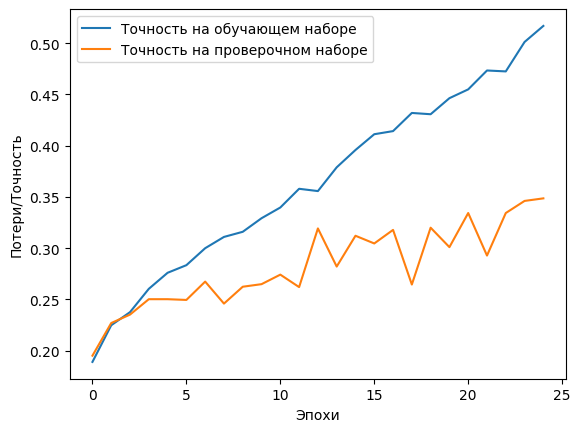

In [22]:
plt.plot(history3.history['categorical_accuracy'], label='Точность на обучающем наборе')
plt.plot(history3.history['val_categorical_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери/Точность')
plt.legend()
plt.show()

Выполним усреднение моделей

In [23]:
def AvgClassifier(models, input_shape, num_classes):
    model_input = layers.Input(shape=input_shape)
    model_outputs = [md(model_input) for md in models]

    x = layers.Average()(model_outputs) 
    x = layers.Dense(32, activation='LeakyReLU')(x) 
    x = layers.Dropout(0.2)(x) 

    model_output = layers.Dense(num_classes, activation='softmax')(x)
    return keras.models.Model(model_input, model_output, name='AvgClassifier_model')

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

# Список объеденяемых моделей
models = [model_DNN, model_CNN]

model_AVG = AvgClassifier(models, (64,64,1), num_classes)

model_AVG.compile(
    optimizer=keras.optimizers.Nadam(0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]) 

model_AVG.summary()

Model: "AvgClassifier_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 DNNClassifier_model (Functiona  (None, 8)           16830472    ['input_1[0][0]']                
 l)                                                                                               
                                                                                                  
 CNNClassifier_model (Functiona  (None, 8)           4820872     ['input_1[0][0]']                
 l)                                                                                               
                                                                                

In [25]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
]

history4 = model_AVG.fit(X_train, y_train, batch_size=512, epochs=25, callbacks=callbacks, validation_split=0.2, verbose=1)

Epoch 1/25
22/22 [==============================] - 4s 106ms/step - loss: 2.0890 - categorical_accuracy: 0.1190 - val_loss: 2.0458 - val_categorical_accuracy: 0.2853 - lr: 0.0010
Epoch 2/25
22/22 [==============================] - 2s 94ms/step - loss: 1.9847 - categorical_accuracy: 0.3160 - val_loss: 1.9776 - val_categorical_accuracy: 0.3064 - lr: 0.0010
Epoch 3/25
22/22 [==============================] - 2s 94ms/step - loss: 1.9007 - categorical_accuracy: 0.3482 - val_loss: 1.9096 - val_categorical_accuracy: 0.3243 - lr: 0.0010
Epoch 4/25
22/22 [==============================] - 2s 94ms/step - loss: 1.8192 - categorical_accuracy: 0.3759 - val_loss: 1.8360 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 5/25
22/22 [==============================] - 2s 94ms/step - loss: 1.7409 - categorical_accuracy: 0.3979 - val_loss: 1.8255 - val_categorical_accuracy: 0.2863 - lr: 0.0010
Epoch 6/25
22/22 [==============================] - 2s 94ms/step - loss: 1.6685 - categorical_accuracy: 0.422

In [26]:
scores = model_AVG.evaluate(X_test, y_test, verbose=0)
print("Точность на тестовых данных: %.2f%%" % (scores[1]*100))

Точность на тестовых данных: 35.92%


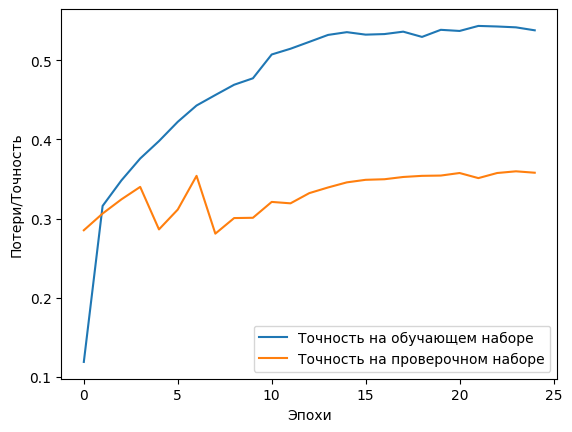

In [27]:
plt.plot(history4.history['categorical_accuracy'], label='Точность на обучающем наборе')
plt.plot(history4.history['val_categorical_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери/Точность')
plt.legend()
plt.show()